# Chest X-ray Dataset for Tuberculosis Segmentation

# Step 1: Import Libraries

In [1]:
import os 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import cv2 
import tensorflow as tf 


from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.applications import ResNet50 
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model 

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Step 2: Load and Explore the Data

In [2]:
# load the MetaData file 
metadata = pd.read_csv('MetaData.csv')

# Check data overview 
print(metadata.head())

print(metadata['ptb'].value_counts()) #check the distribution of TB-positive vs. normal cases

     id gender age    county  ptb                                      remarks
0  1000   male  31  Shenxhen    0                                       normal
1  1001   male  64  Shenxhen    0                                       normal
2  1002   male  35  Shenxhen    0                                       normal
3  1003   male  32  Shenxhen    1               STB,ATB,tuberculosis pleuritis
4  1004   male   2  Shenxhen    1  secondary PTB  in the bilateral upper field
0    359
1    345
Name: ptb, dtype: int64


# Step 3: Load and Preprocess Images and Masks

1. Resize images and masks for uniformity.

2. Normalize images.


In [3]:
image_dir = 'Chest-X-Ray/Chest-X-Ray/image' 

mask_dir = 'Chest-X-Ray/Chest-X-Ray/mask'

In [5]:
# Step 3: Loading Images
IMG_SIZE = 224

def load_images(df, image_dir, mask_dir):
    images = []
    masks = []
    labels = [] 
    
    for _, row in df.iterrows():
        # Load and preprocess the X-ray image 
        img = cv2.imread(os.path.join(image_dir, str(row['id']) + '.png'), cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Image not found for ID: {row['id']}")
            continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = np.stack([img] * 3, axis=-1)  # Convert grayscale to RGB by repeating the channel
        img = img / 255.0  # Normalize 
        
        # Load and preprocess the mask 
        mask = cv2.imread(os.path.join(mask_dir, str(row['id']) + '.png'), cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"Mask not found for ID: {row['id']}")
            continue
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
        mask = mask / 255.0  # Normalize 
        
        images.append(img)
        masks.append(mask)
        labels.append(row['ptb'])
    
    return np.array(images), np.array(masks).reshape(-1, IMG_SIZE, IMG_SIZE, 1), np.array(labels)

# Load data 
images, masks, labels = load_images(metadata, 'Chest-X-Ray/Chest-X-Ray/image', 'Chest-X-Ray/Chest-X-Ray/mask')
print(f"Loaded {images.shape[0]} images and {masks.shape[0]} masks")


Loaded 704 images and 704 masks


# Step 4: Train-test Split

In [6]:
# Step 4: Train-test Split
# Ensure images are 3-channel, and labels are in the correct shape
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)


Data augmentation can improve model robustness.



# Step 5: Data Augmentation

Data augmentation can improve model robustness.

In [7]:
# Step 5: Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

train_gen = datagen.flow(X_train, y_train, batch_size=32)

# Step 6: Build the Classification Model Using Transfer Learning (ResNet50)

1. Use a pretrained model (ResNet50) for transfer learning.


2. Replace final layers for binary classification (TB-positive vs. normal).

In [8]:
# Step 6: Model Setup
# Load ResNet50 without the top layers and specify input shape 
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Add custom layers on top of ResNet50 
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification 

# Build model 
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of ResNet50 to retain pretrained weights 
for layer in base_model.layers:
    layer.trainable = False

# Compile the model 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 7: Train the Model

In [10]:
# Step 7: Model Training
history = model.fit(train_gen, epochs=10, validation_data=(X_val, y_val))


Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 836ms/step - accuracy: 0.4988 - loss: 0.7004 - val_accuracy: 0.5177 - val_loss: 0.6862
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6158 - loss: 0.6694 - val_accuracy: 0.6099 - val_loss: 0.6605
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6352 - loss: 0.6473 - val_accuracy: 0.5319 - val_loss: 0.6660
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6245 - loss: 0.6430 - val_accuracy: 0.6099 - val_loss: 0.6594
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6612 - loss: 0.6265 - val_accuracy: 0.4965 - val_loss: 0.7071
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6278 - loss: 0.6396 - val_accuracy: 0.5390 - val_loss: 0.6862
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5761 - loss: 0.6788 - val_accuracy: 0.4965 - val_loss: 0.7770
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6071 - loss: 0.6627 - val_accuracy: 0.5887 - val_lo

# Step 8: Evaluate the Model

In [11]:
# Predictions on validation data 
y_pred = (model.predict(X_val) > 0.5).astype("int32")

# classification  report 
print(classification_report(y_val, y_pred))

# Accuracy score 
print(f"Accuracy: {accuracy_score(y_val, y_pred)}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 771ms/step
              precision    recall  f1-score   support

           0       0.62      0.88      0.72        72
           1       0.77      0.43      0.56        69

    accuracy                           0.66       141
   macro avg       0.69      0.65      0.64       141
weighted avg       0.69      0.66      0.64       141

Accuracy: 0.6595744680851063


# Step 9: Visualize Training Results

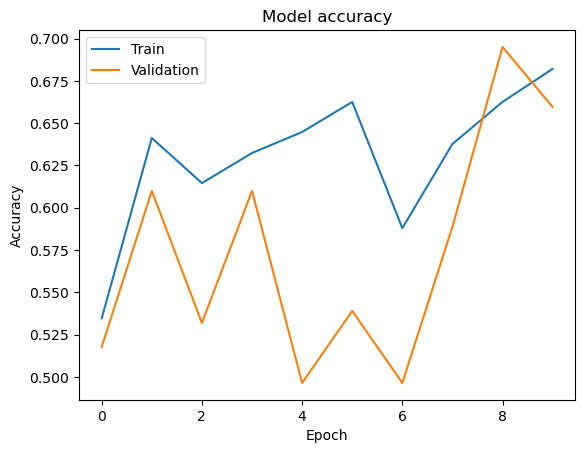

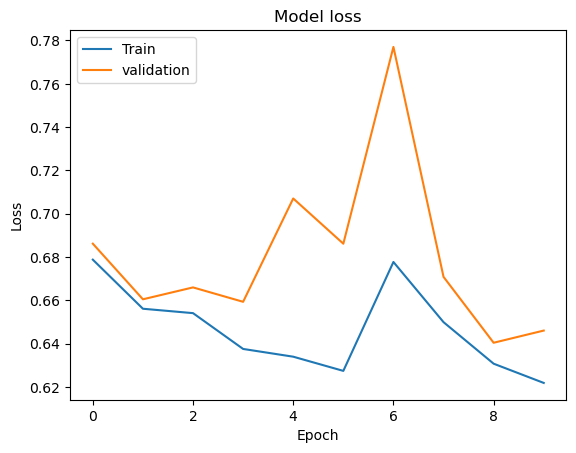

In [15]:
# Plot training & validation accuracy values 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')
plt.show()


# Step 10: Visualize Model Predictions

For a few test images, visualize the predictions with the masks:


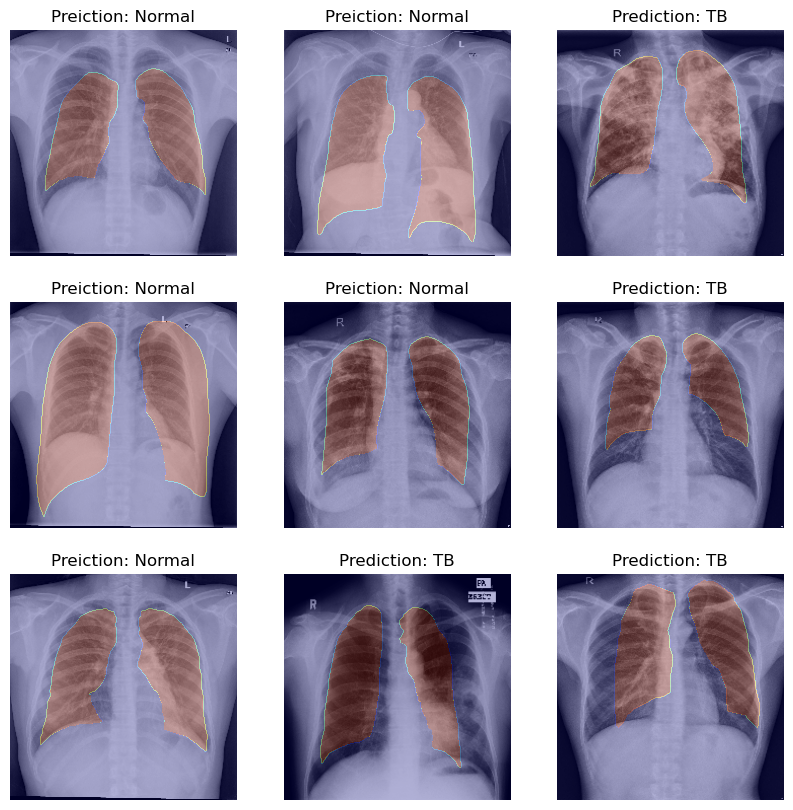

In [17]:
def plot_prediction(images, masks, predictions):
    plt.figure(figsize=(10,10))
    for i in range(9): 
        plt.subplot(3,3, i+1)
        #plt.imshow(images[i].reshape(IMG_SIZE, IMG_SIZE ), cmap='gray')
        plt.imshow(images[i], cmap='gray')
        plt.imshow(masks[i].reshape(IMG_SIZE, IMG_SIZE), alpha=0.3, cmap='jet')  # Overlay mask 
        plt.title("Prediction: TB" if predictions[i] else "Preiction: Normal")
        plt.axis('off')
    plt.show()
    
plot_prediction(X_val[:9], masks[:9], y_pred[:9].flatten())